In [15]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

In [2]:
data_path = r"C:\Users\Reljod\Desktop\Study Materials\kaggle\dataset\titanic"

In [3]:
train_path = os.path.join(data_path, "train.csv")
test_path = os.path.join(data_path, "test.csv")
submission_path = os.path.join(data_path, "gender_submission.csv")

## Checking data

In [4]:
train_raw = pd.read_csv(train_path)

In [5]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_raw.shape

(891, 12)

##### Thoughts
The training data only has <b>891 instances</b>, a miniscule number of data.<br>
The data also have <b>12 features</b>, one as a target feature.<br>


### Make sure to study the features

**pclass**: A proxy for socio-economic status (SES)<br>
> - 1 = Upper <br>
> - 2 = Middle <br>
> - 3 = Lower <br>

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 <br>

**sibsp**: # of siblings / spouses aboard the Titanic <br> 
 >The dataset defines family relations in this way... <br>
 - Sibling = brother, sister, stepbrother, stepsister <br>
 - Spouse = husband, wife (mistresses and fiancés were ignored) <br>

**parch**:  # of parents / children aboard the Titanic <br>
 >The dataset defines family relations in this way... <br>
 - Parent = mother, father <br>
 - Child = daughter, son, stepdaughter, stepson <br>
 - Some children travelled only with a nanny, therefore parch=0 for them. <br>

**ticket**:	Ticket number	

**fare**:	Passenger fare	

**cabin**:	Cabin number

**embarked**: Port of Embarkation <br>
> - C = Cherbourg <br>
> - Q = Queenstown <br>
> - S = Southampton <br>

In [7]:
# Make a copy, it is always advisable to save a copy of the raw train data
df = train_raw.copy()

In [8]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [9]:
df.set_index('PassengerId', inplace=True)

In [10]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Observing the relationship of features to survivability
 - One way of doing this is by **graphing**.

In [11]:
# Setting the plotting style into seaborn style
sns.set()

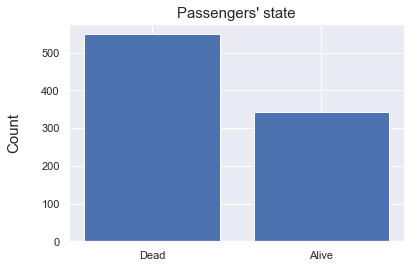

In [16]:
target = df["Survived"]
x_surv = target.value_counts().keys()
y_surv = target.value_counts()
_ = plt.bar(x_surv, y_surv, tick_label=["Dead","Alive"])
_ = plt.title("Passengers' state", {'fontsize': 15})
_ = plt.ylabel("Count", {'fontsize': 15}, labelpad=20)
_ = plt.show()

#### Comment
The training data contains less survived passengers <br>
Let's see if this **imbalanced** will affect our model's prediction later.

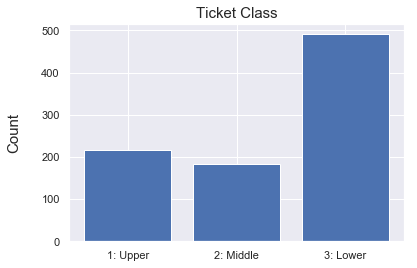

In [17]:
pclass = df["Pclass"]
x_pclass = pclass.value_counts().keys()
y_pclass = pclass.value_counts()
_ = plt.bar(x_pclass, y_pclass, tick_label=['3: Lower', '1: Upper', '2: Middle',])
_ = plt.title("Ticket Class", {'fontsize': 15})
_ = plt.ylabel("Count", {'fontsize': 15}, labelpad=20)
_ = plt.show()

#### Comment
 - There's a lot more lower class than any other classes
 - We can hypothesize that the high frequency of dead passengers are because of the high frequency of lower class tickets. Let's invistigate it further

In [30]:
df.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [21]:
df.mean()

Survived     0.383838
Pclass       2.308642
Age         29.699118
SibSp        0.523008
Parch        0.381594
Fare        32.204208
dtype: float64

In [31]:
df.mode(numeric_only=True).transpose()

,0
Survived,0.00
Pclass,3.00
Age,24.00
SibSp,0.00
Parch,0.00
Fare,8.05


In [27]:
df.std()

Survived     0.486592
Pclass       0.836071
Age         14.526497
SibSp        1.102743
Parch        0.806057
Fare        49.693429
dtype: float64

In [29]:
df.var()

Survived       0.236772
Pclass         0.699015
Age          211.019125
SibSp          1.216043
Parch          0.649728
Fare        2469.436846
dtype: float64

### Cleaning the data

In [34]:
datainfo = df.info()
print(datainfo)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


##### Comment

 1. There's clearly a null value that we must get rid of
 2. We must convert all non-numeric values to numeric before we feed it to the model
 3. Also, we must do a slight feature engineering to this

### Removing Null Values

 + **Cabin has only 204 nun-null values** and its null values can affect our prediction. It is my decision to just remove the whole feature because filling the null values might lead as to a inaccurate prediction. Furthermore, you wont be able to drop rows also because it will affect the number of training samples. Therefore, my say is to just **drop the whole column.**

In [35]:
df.drop(["Cabin"], axis=1, inplace=True)

In [37]:
## Checking if the cabin column is gone...
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [48]:
print(df.Age.describe())
### Looking at the description, we can see that the there's a variety of age groups looking at the std, there's an infant, 
### a senior but most of them lies between 20 to 38 years old age group. The median and the mean also doesn't differ much
### at 28.5.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


##### Comment in Age column
Looking at the description, I decided that I will just fill the nan values into the median of the age column.

In [54]:
df["Age"].fillna(df.Age.median(), inplace=True)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [44]:
print(df["Embarked"].value_counts())
print(df["Embarked"].unique())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
['S' 'C' 'Q' nan]


 - As we can see in the info, there are two missing values in the **Embarked** column and we can choose two ways. One is to just *remove the entire row where there is a missing value* and two, just *fill it with a value* that is mean value or a mode value.
 - I chose dropping the entire row because removing just two rows is insignificant.

In [57]:
### Removing the rows with nan-values
df.dropna(inplace=True)

In [60]:
## Checking again, it seems there is no null values anymore!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
Survived    889 non-null int64
Pclass      889 non-null int64
Name        889 non-null object
Sex         889 non-null object
Age         889 non-null float64
SibSp       889 non-null int64
Parch       889 non-null int64
Ticket      889 non-null object
Fare        889 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB


### Converting Object data to numerical data

In [63]:
df_obj = df.select_dtypes(['object']).copy()

In [64]:
df_obj

,Name,Sex,Ticket,Embarked
PassengerId,,,,
1,"Braund, Mr. Owen Harris",male,A/5 21171,S
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C
3,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,S
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,S
5,"Allen, Mr. William Henry",male,373450,S
6,"Moran, Mr. James",male,330877,Q
7,"McCarthy, Mr. Timothy J",male,17463,S
8,"Palsson, Master. Gosta Leonard",male,349909,S
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,347742,S
